In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt
import time
sys.path.insert(0, "/home/ylu/project/STalign")
from STalign import STalign
sys.path.insert(0, "/home/ylu/project/Benchmark_alignment_methods/scripts/methods")
from my_STAlign import stalign_align

sys.path.insert(0, "/home/ylu/project")
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load data
data_folder = "../../data/BARseq/BARseq_Perturbed/"
results_folder = "./results/STAlign/"
Path(results_folder).mkdir(parents=True, exist_ok=True)

In [3]:
i = 10
slice1 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i)))
slice2 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i+1)))
# subsample
subsample1 = np.random.choice(slice1.shape[0], subsample_num, replace=False) if slice1.shape[0] > subsample_num else np.arange(slice1.shape[0])
subsample2 = np.random.choice(slice2.shape[0], subsample_num, replace=False) if slice2.shape[0] > subsample_num else np.arange(slice2.shape[0])
slice1 = slice1[subsample1,:]
slice2 = slice2[subsample2,:]

In [7]:
slice1

View of AnnData object with n_obs × n_vars = 20000 × 114
    obs: 'cluster', 'slice_id', 'simplify_cluster'
    obsm: 'align_spatial', 'perturbed_spatial', 'spatial', 'spatial_CCF', 'spatial_raw'

In [4]:
spatial_key = 'perturbed_spatial'

0 of 20000
10000 of 20000
19999 of 20000


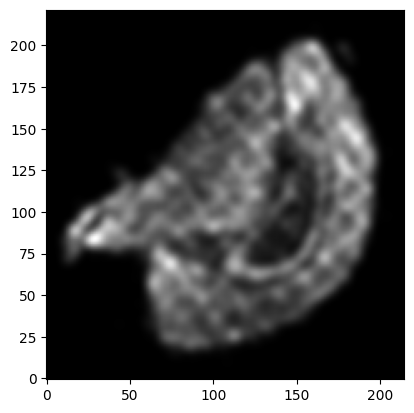

In [6]:
factor = 20
xI = slice1.obsm[spatial_key][:,0] * factor
yI = slice1.obsm[spatial_key][:,1] * factor
xJ = slice2.obsm[spatial_key][:,0] * factor
yJ = slice2.obsm[spatial_key][:,1] * factor
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

In [15]:
spatial_key = "spatial"
key_added = "align_spatial"
from tqdm import tqdm
for i in tqdm(range(1, 40)):
    slice1 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i)))
    slice2 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i+1)))
    if i > 1:
        slice1.obsm['spatial'] = align_slices[1].obsm[key_added].copy()
    align_slices = stalign_align(
        models = [slice1, slice2],
        spatial_key = 'spatial',
        key_added = key_added,
        device = "cuda:0",
        scale=20,
    )
    
    results = {'spatial_2': align_slices[1].obsm[key_added]}
    np.save(os.path.join(results_folder, "slice_{}_{}.npy".format(i,i+1)), results, allow_pickle=True)

  0%|                               | 0/39 [00:00<?, ?it/s]/home/ylu/project/STalign/STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/home/ylu/project/STalign/STalign/STalign.py:1045: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: i